# IRIS DATASET

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA

import pennylane as qml
from pennylane import numpy as np

from helpers import *

In [2]:
X, y = load_iris(return_X_y=True)
y = y - 1

In [3]:
X, test_X, y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)
X = np.array(X, requires_grad=False)
y = np.array(y, requires_grad=False)

In [4]:
# Dimensionality reduction
# t-SNE
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
X_tsne = tsne.fit_transform(X)
test_X_tsne = tsne.fit_transform(test_X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
test_X_pca = pca.fit_transform(test_X)

# Isomap
isomap = Isomap()
X_isomap = isomap.fit_transform(X)
test_X_isomap = isomap.fit_transform(test_X)

/home/mudit/miniconda3/envs/qudit/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/mudit/miniconda3/envs/qudit/lib/python3.9/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/mudit/miniconda3/envs/qudit/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:348: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/mudit/miniconda3/envs/qudit/lib/python3.9/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity struc

In [5]:
dev = qml.device("default.qutrit", wires=4)

n_layers = 2
n_features = 4

In [6]:
def rot(weights, wires):
    qml.TRY(weights[0], wires=wires, subspace=[0, 1])
    qml.TRY(weights[1], wires=wires, subspace=[0, 2])
    qml.TRY(weights[2], wires=wires, subspace=[0, 1])
    qml.TRZ(weights[3], wires=wires, subspace=[0, 2])
    qml.TRZ(weights[4], wires=wires, subspace=[0, 1])
    qml.TRY(weights[5], wires=wires, subspace=[0, 1])
    qml.TRY(weights[6], wires=wires, subspace=[0, 2])
    qml.TRY(weights[7], wires=wires, subspace=[0, 1])

obs = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]], requires_grad=False)

def layer(point, weights):
    p_len = len(point)
    
    for i in range(p_len):
        rot(weights[i], wires=i)
    for i in range(p_len, 0):
        qml.TAdd(wires=[i % p_len, (i-1) % p_len])

@qml.qnode(dev)
def iris_model(point, weights):

    # Angle embedding
    for i, p in enumerate(point):
        qml.TRX(p, wires=i, subspace=[0, 1])

    for n in range(n_layers):
        layer(point, weights[n])

    return qml.expval(qml.THermitian(obs, wires=0))

In [7]:
weights = np.random.normal(size=(n_layers, n_features, 8))
our_preds = make_predictions(X, iris_model, weights, classes=3)

## t-SNE

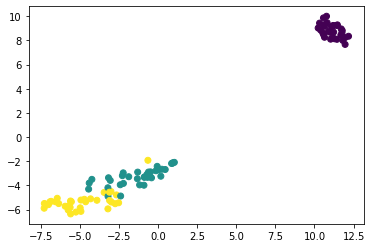

In [8]:
plot_data(X_tsne, y)

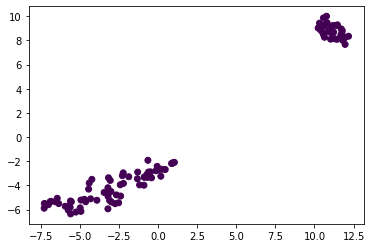

In [9]:
plot_data(X_tsne, our_preds)

## PCA

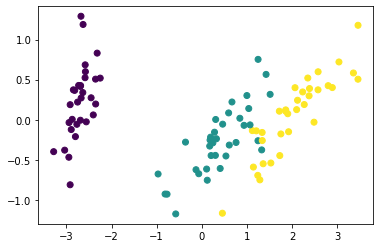

In [10]:
plot_data(X_pca, y)

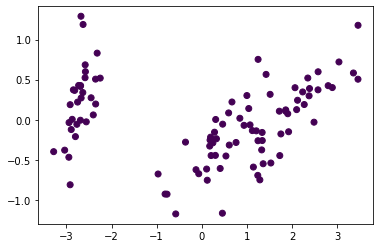

In [11]:
plot_data(X_pca, our_preds)

## Isomap

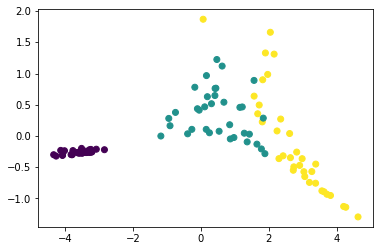

In [12]:
plot_data(X_isomap, y)

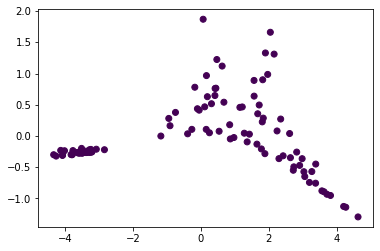

In [13]:
plot_data(X_isomap, our_preds)

In [14]:
loss = make_loss_function(X, y, iris_model)

In [15]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

n_its = 100

loss_track = []

for it in range(n_its):
    weights, _loss = opt.step_and_cost(loss, weights)
    if it % 5 == 0:
        our_preds = make_predictions(X, iris_model, weights, classes=3)
        print(f"Loss at iteration {it:2} = {_loss: .10f}  Accuracy = {compute_accuracy(our_preds, y): .2f}")
    loss_track.append(_loss)

Loss at iteration  0 =  0.9701031851  Accuracy =  0.35
Loss at iteration  5 =  0.3630047508  Accuracy =  0.54
Loss at iteration 10 =  0.2784398741  Accuracy =  0.61
Loss at iteration 15 =  0.2631580042  Accuracy =  0.63
Loss at iteration 20 =  0.2591478776  Accuracy =  0.63
Loss at iteration 25 =  0.2567658694  Accuracy =  0.63
Loss at iteration 30 =  0.2549474715  Accuracy =  0.63
Loss at iteration 35 =  0.2534994869  Accuracy =  0.63
Loss at iteration 40 =  0.2523283160  Accuracy =  0.69
Loss at iteration 45 =  0.2513694056  Accuracy =  0.69
Loss at iteration 50 =  0.2505755053  Accuracy =  0.69
Loss at iteration 55 =  0.2499114106  Accuracy =  0.69
Loss at iteration 60 =  0.2493505602  Accuracy =  0.69
Loss at iteration 65 =  0.2488726826  Accuracy =  0.69
Loss at iteration 70 =  0.2484621375  Accuracy =  0.69
Loss at iteration 75 =  0.2481067323  Accuracy =  0.69
Loss at iteration 80 =  0.2477968689  Accuracy =  0.71
Loss at iteration 85 =  0.2475249214  Accuracy =  0.71
Loss at it

In [16]:
our_preds = make_predictions(X, iris_model, weights, classes=3)
test_preds = make_predictions(test_X, iris_model, weights, classes=3)
print(f"Training prediction accuracy: {compute_accuracy(our_preds, y)}")
print(f"Testing prediction accuracy: {compute_accuracy(test_preds, test_y)}")

Training prediction accuracy: 0.71
Testing prediction accuracy: 0.68


## t-SNE

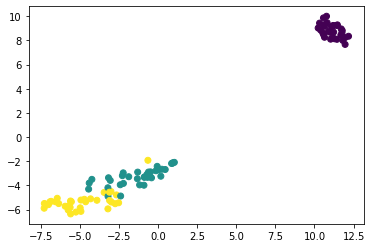

In [17]:
plot_data(X_tsne, y)

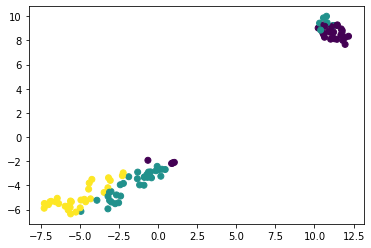

In [18]:
plot_data(X_tsne, our_preds)

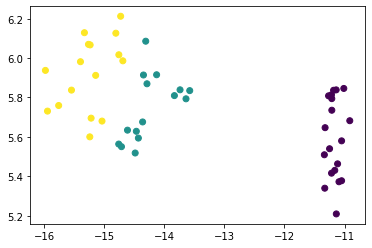

In [19]:
plot_data(test_X_tsne, test_y)

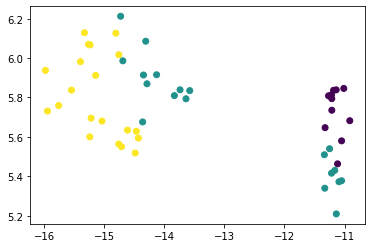

In [20]:
plot_data(test_X_tsne, test_preds)

## PCA

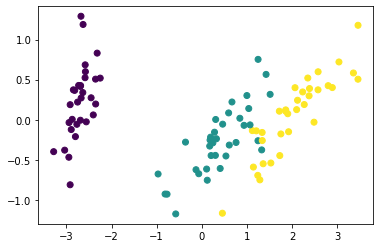

In [21]:
plot_data(X_pca, y)

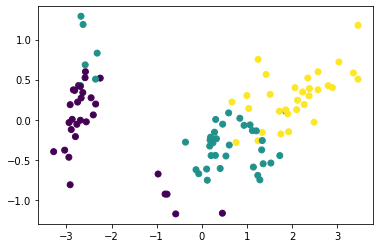

In [22]:
plot_data(X_pca, our_preds)

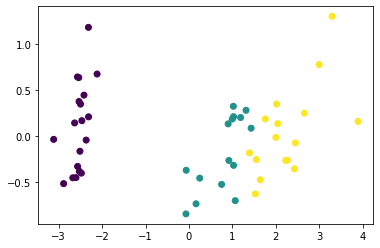

In [23]:
plot_data(test_X_pca, test_y)

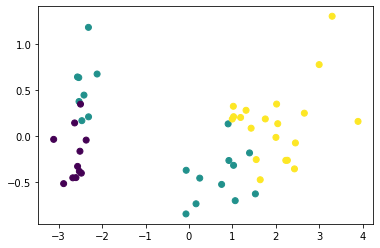

In [24]:
plot_data(test_X_pca, test_preds)

## Isomap

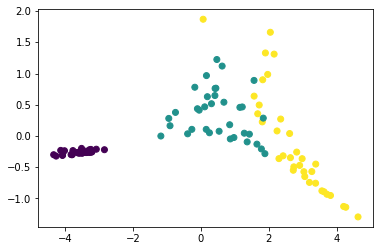

In [25]:
plot_data(X_isomap, y)

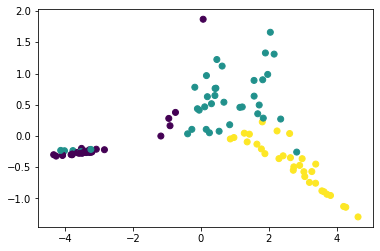

In [26]:
plot_data(X_isomap, our_preds)

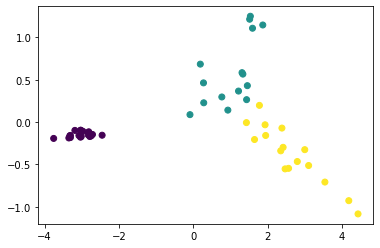

In [27]:
plot_data(test_X_isomap, test_y)

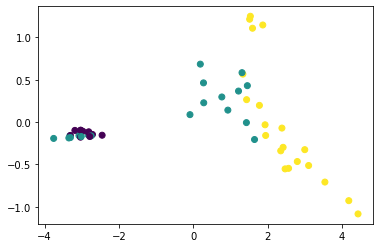

In [28]:
plot_data(test_X_isomap, test_preds)